In [8]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import scipy as sp

import seaborn as sns
sns.set(style='ticks', context='paper',
        rc={'font.size': 6, 
            'axes.titlesize': 7,
                                   'axes.labelsize': 7,
                                   'axes.labelpad': 2,
                                   'xtick.labelsize': 5,
                                   'ytick.labelsize': 5,
                                   'legend.title_fontsize' : 5.5,
                                   'legend.fontsize' : 5.5,
                                   'legend.markerscale': 0.5,
                                   'axes.spines.top': False,
                                   'axes.spines.right': False,
                                   'axes.linewidth': 0.4,
                                   'xtick.major.width': 0.4,
                                   'ytick.major.width': 0.4,
                                   'xtick.major.size': 2.5,
                                   'ytick.major.size': 2.5,
                                   'xtick.minor.size': 1.5,
                                   'ytick.minor.size': 1.5,
                                   'xtick.minor.width': 0.2,
                                   'ytick.minor.width': 0.2,
                                   'figure.constrained_layout.use': True,
                                   'figure.dpi': 200})

id_columns = ['architecture', 'task', 'kind', 'source', 'layer']

tf_to_pt_layer_map = {'encode_2': 'layer1.0.relu', 'encode_3': 'layer1.1.relu', 
                      'encode_4': 'layer2.0.relu', 'encode_5': 'layer2.1.relu', 
                      'encode_6': 'layer3.0.relu', 'encode_7': 'layer3.1.relu', 
                      'encode_8': 'layer4.0.relu', 'encode_9': 'layer4.1.relu'}

position_tf_to_pt_map = {}
for l in ['encode_8', 'encode_9']:
    for x in range(7):
        for y in range(7):
            p = f'.position{x}x{y}'
            tf = l+p
            if l == 'encode_8':
                position_tf_to_pt_map[tf] = 'layer4.0.relu'+p
            if l == 'encode_9':
                position_tf_to_pt_map[tf] = 'layer4.1.relu'+p

#data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'), pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),on=id_columns)


In [2]:
import pandas as pd
from matplotlib import pyplot as plt
an = pd.read_csv('/home/wtownle1/encoder_dimensionality/tests/AtlasNetWeights')
c2 = an.iloc[[1]]

#sns.distplot(weights)
plt.hist(c2)
plt.show()

/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6613: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/home/wtownle1/.conda/envs/encoder-dimensionality/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6614: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


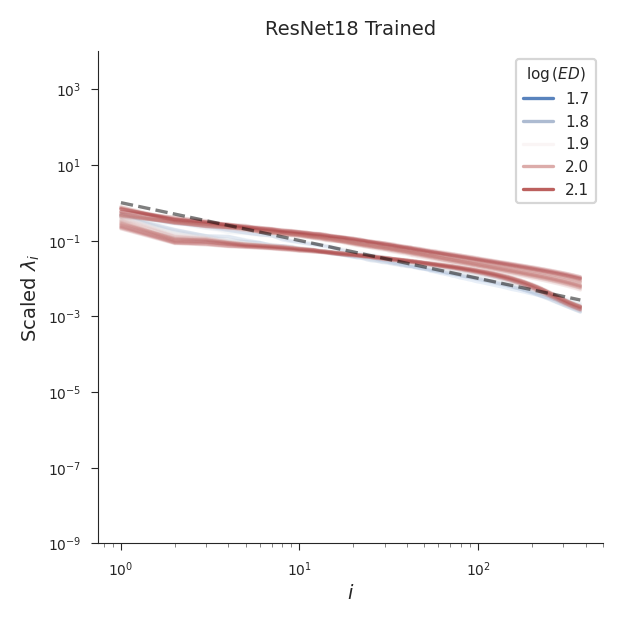

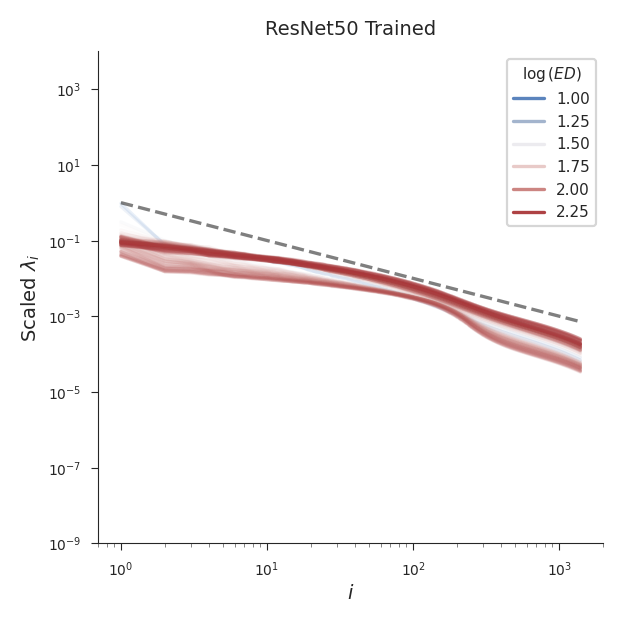

In [3]:
#Trained resnets (all layers 4 & above)
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
#data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)
data = data[data['layer'] > 'layer3.6.relu']
data['id'] = data[id_columns].sum(axis='columns')

data18 = data[data['architecture'] == 'ResNet18']
data50 = data[data['architecture'] == 'ResNet50']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier18 = data18.groupby(id_columns)['n'].transform(is_outlier)
data18 = data18[~outlier18]
outlier50 = data50.groupby(id_columns)['n'].transform(is_outlier)
data50 = data50[~outlier50]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var18 = data18.groupby(id_columns).apply(get_scaled_var)
scaled_var18 = scaled_var18.reset_index(id_columns, drop=True)
data18['scaled_variance'] = scaled_var18
scaled_var50 = data50.groupby(id_columns).apply(get_scaled_var)
scaled_var50 = scaled_var50.reset_index(id_columns, drop=True)
data50['scaled_variance'] = scaled_var50

# Log(ED)
data18['log_ed'] = np.log10(data18['effective dimensionality'])
data50['log_ed'] = np.log10(data50['effective dimensionality'])

#ResNet18
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data18, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data18.n.max()], [1, 1 / data18.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet18 Trained')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#ResNet50
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data50, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data50.n.max()], [1, 1 / data50.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet50 Trained')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


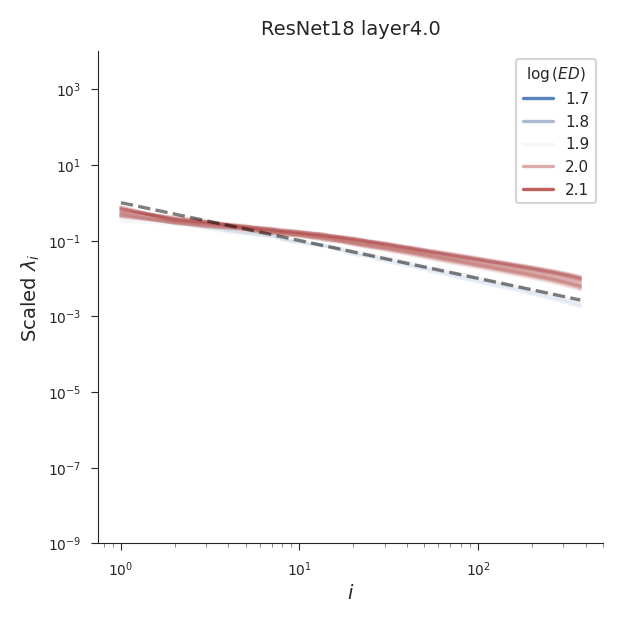

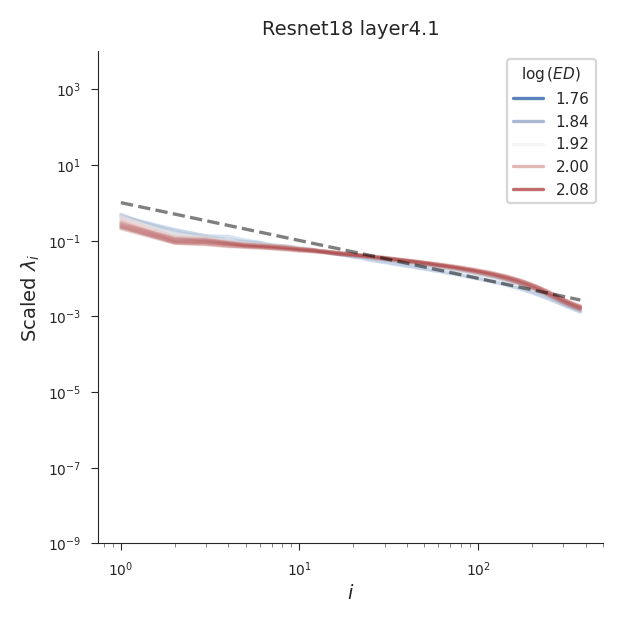

In [4]:
#Trained Resnet18 layer 4.0 and 4.1 separately
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
data = data[data['architecture'] == 'ResNet18']
data['id'] = data[id_columns].sum(axis='columns')

data40 = data[data['layer'] > 'layer3.6.relu']
data40 = data40[data40['layer'] < 'layer4.1.relu.position0x0']
data41 = data[data['layer'] > 'layer4.0.relu.position6x6']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier40 = data40.groupby(id_columns)['n'].transform(is_outlier)
data40 = data40[~outlier40]
outlier41 = data41.groupby(id_columns)['n'].transform(is_outlier)
data41 = data41[~outlier41]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var40 = data40.groupby(id_columns).apply(get_scaled_var)
scaled_var40 = scaled_var40.reset_index(id_columns, drop=True)
data40['scaled_variance'] = scaled_var40
scaled_var41 = data41.groupby(id_columns).apply(get_scaled_var)
scaled_var41 = scaled_var41.reset_index(id_columns, drop=True)
data41['scaled_variance'] = scaled_var41

# Log(ED)
data40['log_ed'] = np.log10(data40['effective dimensionality'])
data41['log_ed'] = np.log10(data41['effective dimensionality'])

#layer 4.0
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data40, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data40.n.max()], [1, 1 / data40.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet18 layer4.0')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.1
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data41, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data41.n.max()], [1, 1 / data41.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet18 layer4.1')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

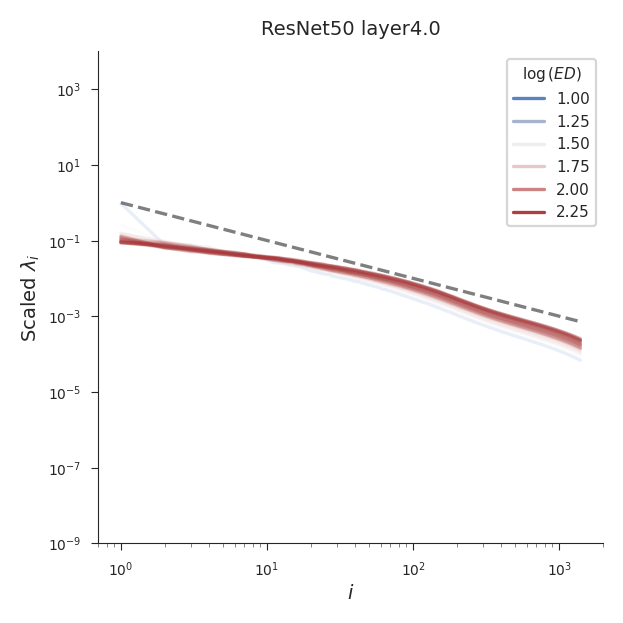

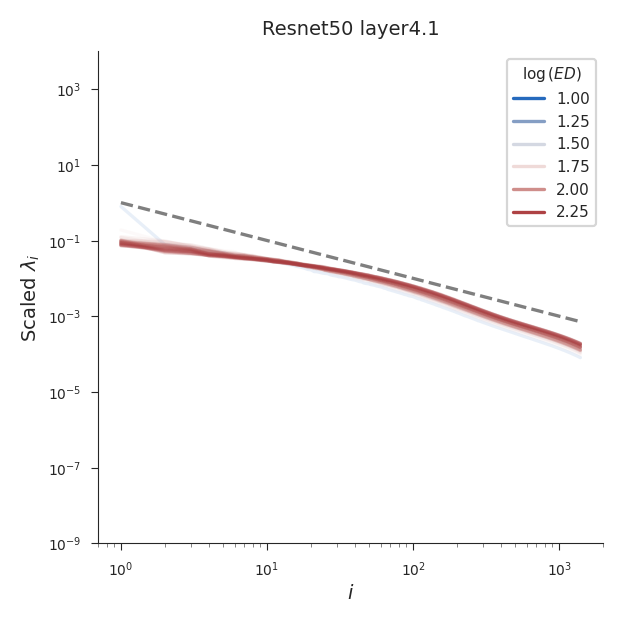

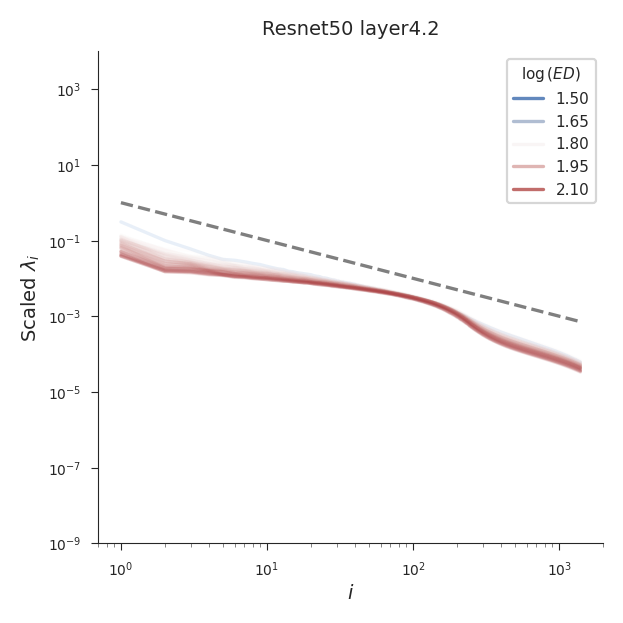

In [5]:
#Trained Resnet50 layer 4.0, 4.1, and 4.2 separately
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
data = data[data['architecture'] == 'ResNet50']
data['id'] = data[id_columns].sum(axis='columns')

data40 = data[data['layer'] > 'layer3.6.relu']
data40 = data40[data40['layer'] < 'layer4.1.relu.position0x0']
data41 = data[data['layer'] > 'layer4.0.relu.position6x6']
data41 = data41[data41['layer'] < 'layer4.2.relu.position0x0']
data42 = data[data['layer'] > 'layer4.1.relu.position6x6']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier40 = data40.groupby(id_columns)['n'].transform(is_outlier)
data40 = data40[~outlier40]
outlier41 = data41.groupby(id_columns)['n'].transform(is_outlier)
data41 = data41[~outlier41]
outlier42 = data42.groupby(id_columns)['n'].transform(is_outlier)
data42 = data42[~outlier42]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var40 = data40.groupby(id_columns).apply(get_scaled_var)
scaled_var40 = scaled_var40.reset_index(id_columns, drop=True)
data40['scaled_variance'] = scaled_var40
scaled_var41 = data41.groupby(id_columns).apply(get_scaled_var)
scaled_var41 = scaled_var41.reset_index(id_columns, drop=True)
data41['scaled_variance'] = scaled_var41
scaled_var42 = data42.groupby(id_columns).apply(get_scaled_var)
scaled_var42 = scaled_var42.reset_index(id_columns, drop=True)
data42['scaled_variance'] = scaled_var42

# Log(ED)
data40['log_ed'] = np.log10(data40['effective dimensionality'])
data41['log_ed'] = np.log10(data41['effective dimensionality'])
data42['log_ed'] = np.log10(data42['effective dimensionality'])

#layer 4.0
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data40, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data40.n.max()], [1, 1 / data40.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet50 layer4.0')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.1
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data41, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data41.n.max()], [1, 1 / data41.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet50 layer4.1')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.2
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data42, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data42.n.max()], [1, 1 / data42.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet50 layer4.2')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

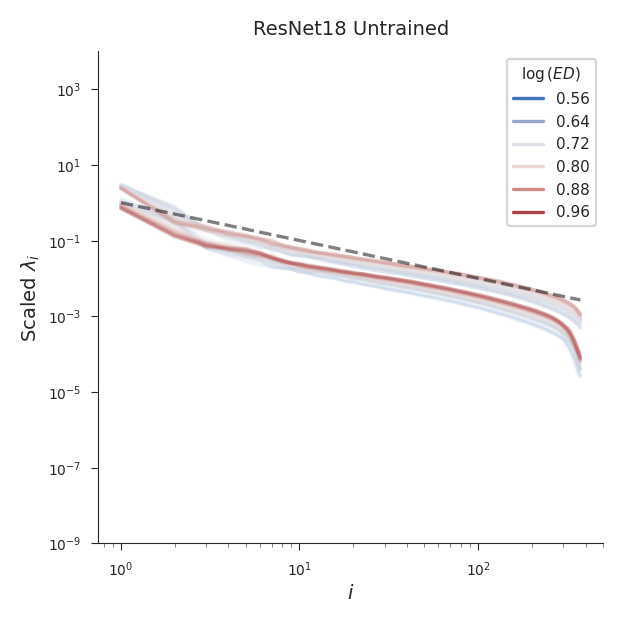

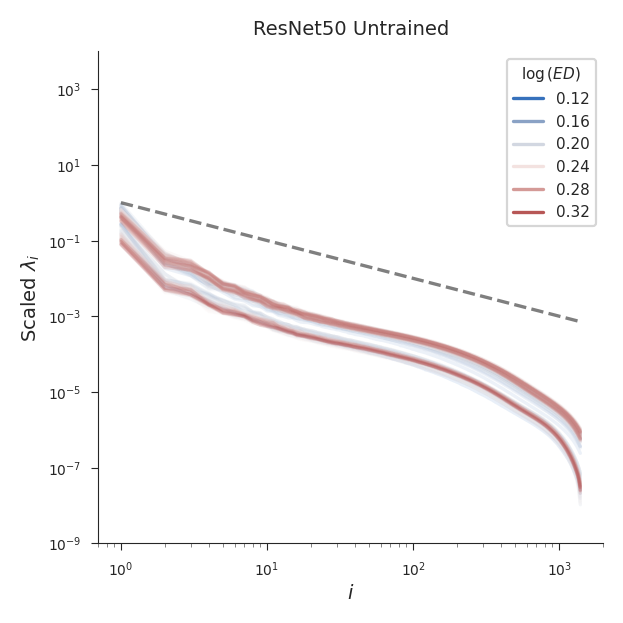

In [6]:
#Untrained resnets (all layers 4 & above)
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)

data = data[data['layer'] > 'layer3.6.relu']
data = data[data['kind'] == 'Untrained']
data['id'] = data[id_columns].sum(axis='columns')

data18 = data[data['architecture'] == 'ResNet18']
data50 = data[data['architecture'] == 'ResNet50']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier18 = data18.groupby(id_columns)['n'].transform(is_outlier)
data18 = data18[~outlier18]
outlier50 = data50.groupby(id_columns)['n'].transform(is_outlier)
data50 = data50[~outlier50]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var18 = data18.groupby(id_columns).apply(get_scaled_var)
scaled_var18 = scaled_var18.reset_index(id_columns, drop=True)
data18['scaled_variance'] = scaled_var18
scaled_var50 = data50.groupby(id_columns).apply(get_scaled_var)
scaled_var50 = scaled_var50.reset_index(id_columns, drop=True)
data50['scaled_variance'] = scaled_var50

# Log(ED)
data18['log_ed'] = np.log10(data18['effective dimensionality'])
data50['log_ed'] = np.log10(data50['effective dimensionality'])

#ResNet18
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data18, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data18.n.max()], [1, 1 / data18.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet18 Untrained')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#ResNet50
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data50, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data50.n.max()], [1, 1 / data50.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet50 Untrained')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


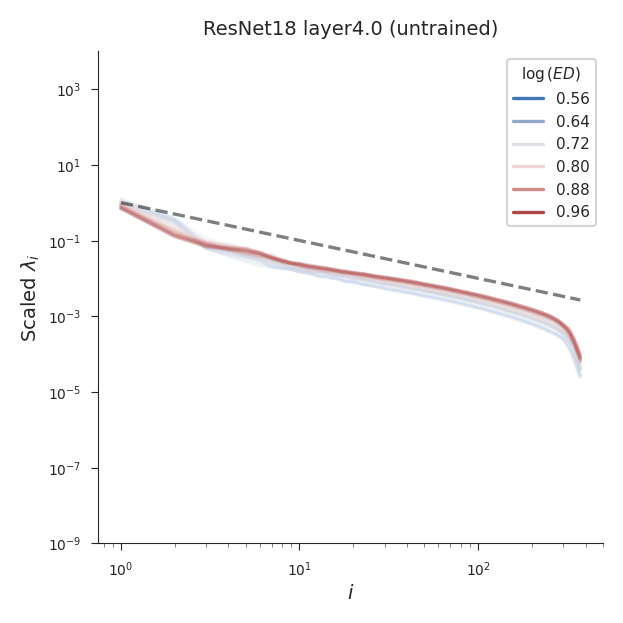

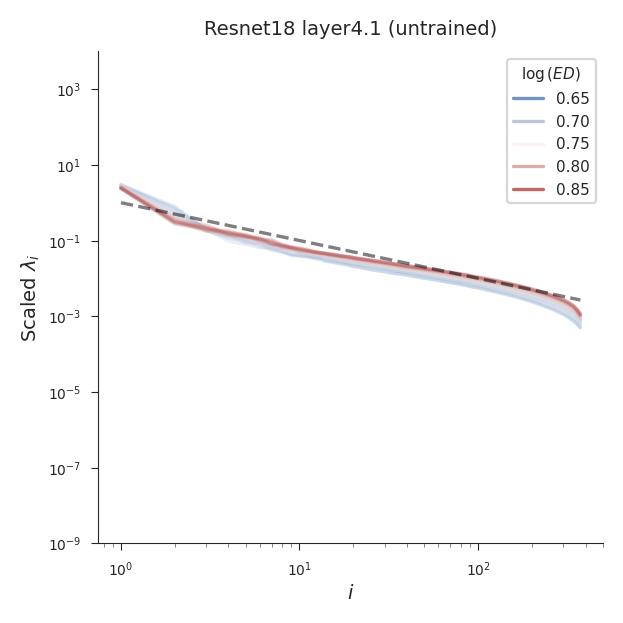

In [7]:
#Untrained Resnet18 layer 4.0 and 4.1 separately
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
data = data[data['architecture'] == 'ResNet18']
data = data[data['kind'] == 'Untrained']
data['id'] = data[id_columns].sum(axis='columns')

data40 = data[data['layer'] > 'layer3.6.relu']
data40 = data40[data40['layer'] < 'layer4.1.relu.position0x0']
data41 = data[data['layer'] > 'layer4.0.relu.position6x6']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier40 = data40.groupby(id_columns)['n'].transform(is_outlier)
data40 = data40[~outlier40]
outlier41 = data41.groupby(id_columns)['n'].transform(is_outlier)
data41 = data41[~outlier41]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var40 = data40.groupby(id_columns).apply(get_scaled_var)
scaled_var40 = scaled_var40.reset_index(id_columns, drop=True)
data40['scaled_variance'] = scaled_var40
scaled_var41 = data41.groupby(id_columns).apply(get_scaled_var)
scaled_var41 = scaled_var41.reset_index(id_columns, drop=True)
data41['scaled_variance'] = scaled_var41

# Log(ED)
data40['log_ed'] = np.log10(data40['effective dimensionality'])
data41['log_ed'] = np.log10(data41['effective dimensionality'])

#layer 4.0
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data40, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data40.n.max()], [1, 1 / data40.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet18 layer4.0 (untrained)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.1
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data41, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data41.n.max()], [1, 1 / data41.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet18 layer4.1 (untrained)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')

#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

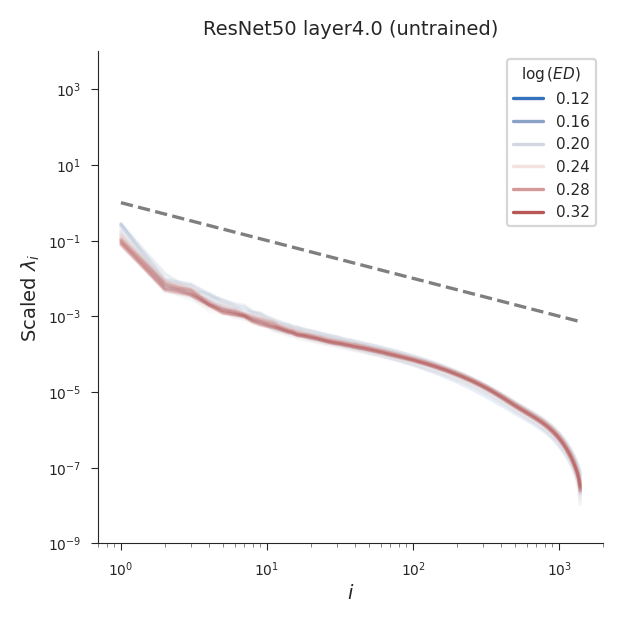

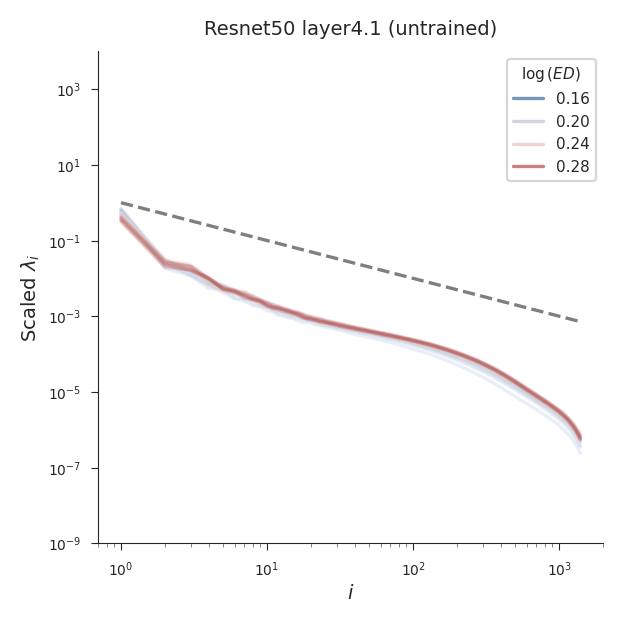

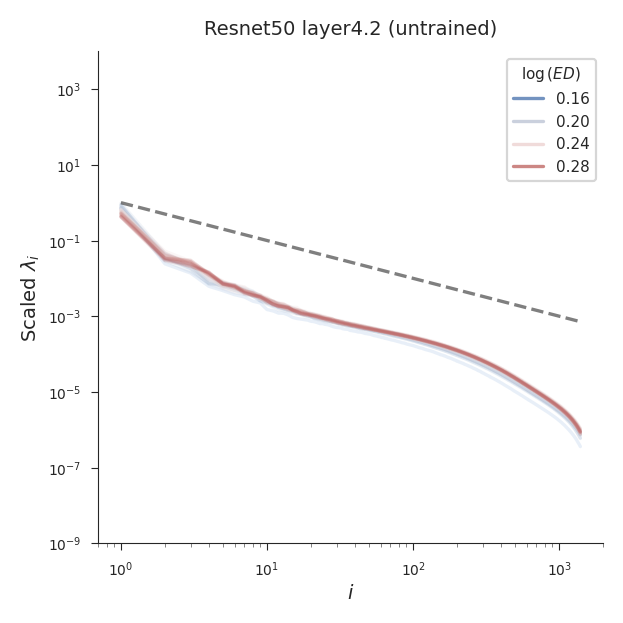

In [8]:
#Trained Resnet50 layer 4.0, 4.1, and 4.2 separately
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
data = data[data['architecture'] == 'ResNet50']
data = data[data['kind'] == 'Untrained']
data['id'] = data[id_columns].sum(axis='columns')

data40 = data[data['layer'] > 'layer3.6.relu']
data40 = data40[data40['layer'] < 'layer4.1.relu.position0x0']
data41 = data[data['layer'] > 'layer4.0.relu.position6x6']
data41 = data41[data41['layer'] < 'layer4.2.relu.position0x0']
data42 = data[data['layer'] > 'layer4.1.relu.position6x6']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier40 = data40.groupby(id_columns)['n'].transform(is_outlier)
data40 = data40[~outlier40]
outlier41 = data41.groupby(id_columns)['n'].transform(is_outlier)
data41 = data41[~outlier41]
outlier42 = data42.groupby(id_columns)['n'].transform(is_outlier)
data42 = data42[~outlier42]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var40 = data40.groupby(id_columns).apply(get_scaled_var)
scaled_var40 = scaled_var40.reset_index(id_columns, drop=True)
data40['scaled_variance'] = scaled_var40
scaled_var41 = data41.groupby(id_columns).apply(get_scaled_var)
scaled_var41 = scaled_var41.reset_index(id_columns, drop=True)
data41['scaled_variance'] = scaled_var41
scaled_var42 = data42.groupby(id_columns).apply(get_scaled_var)
scaled_var42 = scaled_var42.reset_index(id_columns, drop=True)
data42['scaled_variance'] = scaled_var42

# Log(ED)
data40['log_ed'] = np.log10(data40['effective dimensionality'])
data41['log_ed'] = np.log10(data41['effective dimensionality'])
data42['log_ed'] = np.log10(data42['effective dimensionality'])

#layer 4.0
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data40, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data40.n.max()], [1, 1 / data40.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='ResNet50 layer4.0 (untrained)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.1
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data41, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data41.n.max()], [1, 1 / data41.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet50 layer4.1 (untrained)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#layer 4.2
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data42, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data42.n.max()], [1, 1 / data42.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Resnet50 layer4.2 (untrained)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

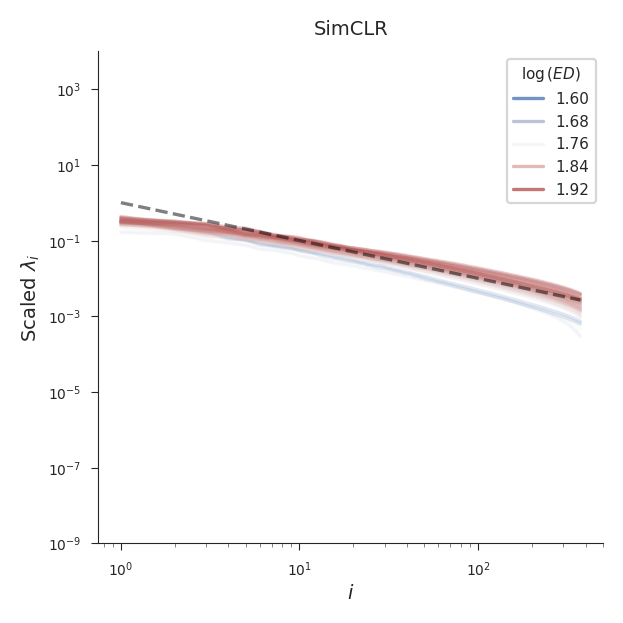

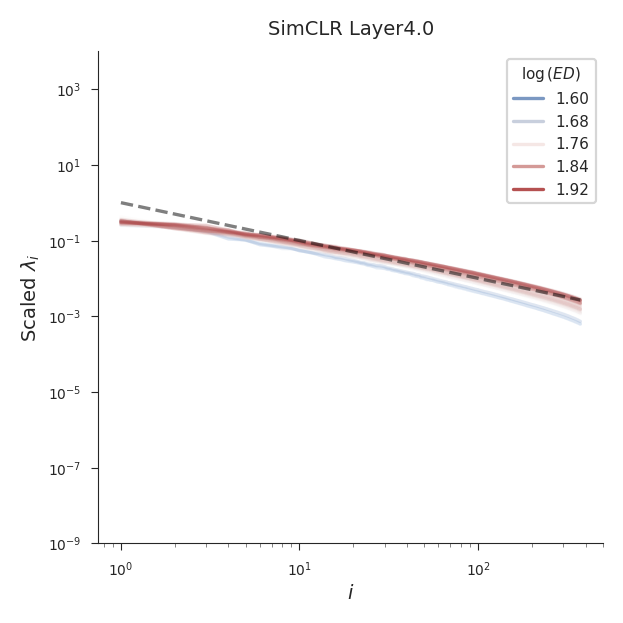

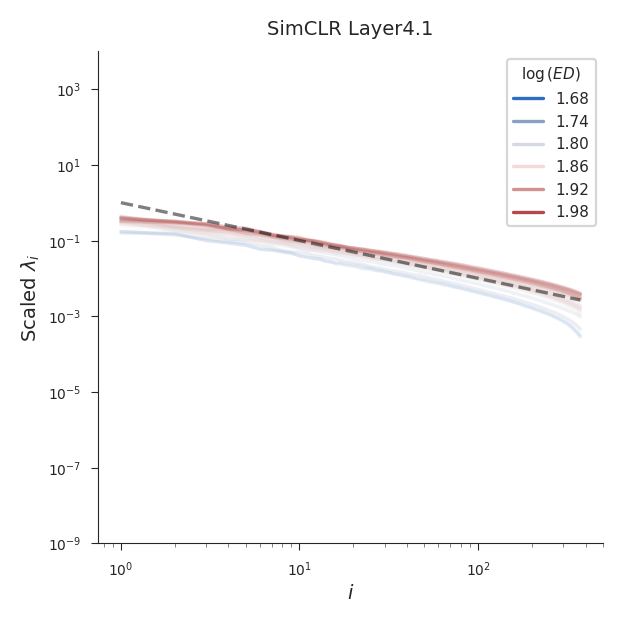

In [9]:
#SimCLR together and separate
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'../../results_marcc/spatialPCA/eigspectra_simclr|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'../../results_marcc/spatialPCA/eigmetrics_simclr|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)
data.loc[:, 'layer'] = data['layer'].replace(position_tf_to_pt_map)
data.loc[:, 'layer'] = data['layer'].replace(tf_to_pt_layer_map)

#data = data[data['layer'] > 'encode_7']
#for l in data['layer']:
#    split = l.split('.position',1)
#    tf_layer = split[0]
#    if tf_layer == 'encode_8':
#        pytorch_layer = 'layer4.0.relu'
#    elif tf_layer == 'encode_9':
#        pytorch_layer = 'layer4.1.relu'
#    new_layer = pytorch_layer + '.position' + split[1]
#    data.loc[:,'layer'] = data['layer'].replace(l,new_layer)


data['id'] = data[id_columns].sum(axis='columns')
data40 = data[data['layer'] > 'layer3.6.relu']
data40 = data[data['layer'] < 'layer4.1.relu.position0x0']
data41 = data[data['layer'] > 'layer4.0.relu.position6x6']


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]
outlier40 = data40.groupby(id_columns)['n'].transform(is_outlier)
data40 = data40[~outlier40]
outlier41 = data41.groupby(id_columns)['n'].transform(is_outlier)
data41 = data41[~outlier41]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var
scaled_var40 = data40.groupby(id_columns).apply(get_scaled_var)
scaled_var40 = scaled_var40.reset_index(id_columns, drop=True)
data40['scaled_variance'] = scaled_var40
scaled_var41 = data41.groupby(id_columns).apply(get_scaled_var)
scaled_var41 = scaled_var41.reset_index(id_columns, drop=True)
data41['scaled_variance'] = scaled_var41

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])
data40['log_ed'] = np.log10(data40['effective dimensionality'])
data41['log_ed'] = np.log10(data41['effective dimensionality'])

#Both layers
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='SimCLR')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#Layer4.0
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data40, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data40.n.max()], [1, 1 / data40.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='SimCLR Layer4.0')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()

#Layer4.1
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data41, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data41.n.max()], [1, 1 / data41.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='SimCLR Layer4.1')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


In [ ]:
#alpha vs layer
#alpha vs position
#   & ED

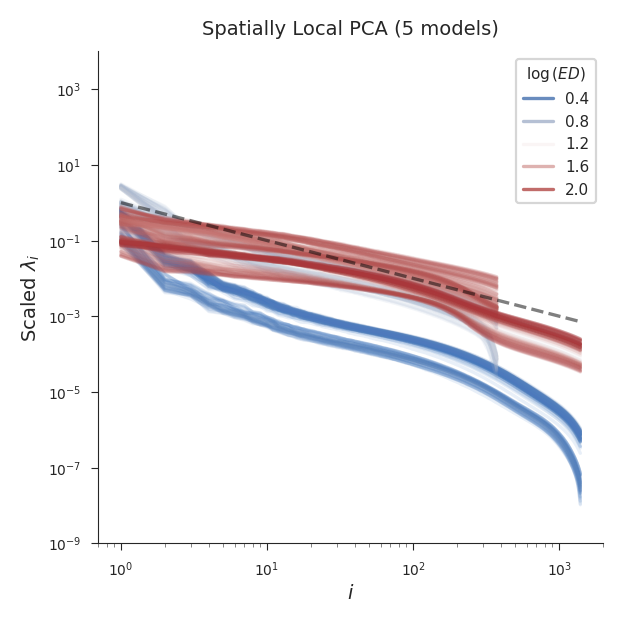

In [17]:
#All together
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_5x|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_5x|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)

data = data[data['layer'] > 'layer3.6.relu']
data['id'] = data[id_columns].sum(axis='columns')


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

#R
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Spatially Local PCA (5 models)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


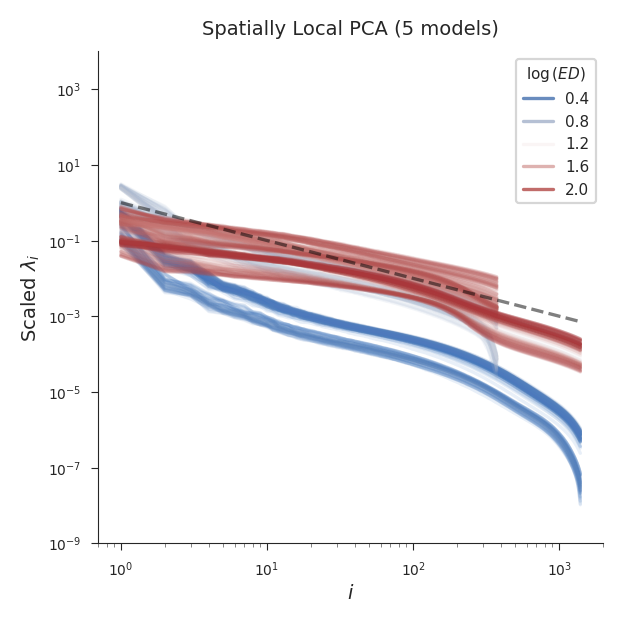

In [ ]:
#untrained
dataset = 'imagenet'
data = pd.merge(pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_5x|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_5x|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                on=id_columns)

data = data[data['layer'] > 'layer3.6.relu']
data['id'] = data[id_columns].sum(axis='columns')


# Remove outlier low-variance points at the final PCs
def is_outlier(i):
    i = np.log(i)
    cutoff = 0.95 * i.iloc[-1]
    return i > cutoff

outlier = data.groupby(id_columns)['n'].transform(is_outlier)
data = data[~outlier]

# Set y-intercept to 1
def get_scaled_var(x):
    i, y = x['n'].values, x['variance'].values
    i, y = np.log(i), np.log(y)
    intercept = LinearRegression().fit(i.reshape(-1, 1), y).intercept_
    intercept = np.exp(intercept)
    return x['variance'] / intercept

scaled_var = data.groupby(id_columns).apply(get_scaled_var)
scaled_var = scaled_var.reset_index(id_columns, drop=True)
data['scaled_variance'] = scaled_var

# Log(ED)
data['log_ed'] = np.log10(data['effective dimensionality'])

#R
fig, ax = plt.subplots(figsize=(3, 3))

sns.lineplot(data=data, x='n', y='scaled_variance', hue='log_ed',
             units='id', alpha=0.1, estimator=None,
             palette=sns.color_palette('vlag', as_cmap=True), ax=ax)
ax.plot([1, data.n.max()], [1, 1 / data.n.max()], linestyle='--', color='black', alpha=0.5)
ax.set(xlabel=r'$i$', ylabel=r'Scaled $\lambda_i$', xscale='log', yscale='log', title='Spatially Local PCA (5 models)')
ax.set_ylim(bottom=10**(-9), top=10**4)
ax.legend(title=r'$\log{(ED)}$')
#plt.savefig('saved/results_eigspectrum_vs_ed.png', dpi=300)
plt.show()


In [ ]:
dataset = 'imagenet'
#print(position_tf_to_pt_map)

metrics = pd.concat([pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                     pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                     pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_simclr|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv')])
metrics = metrics.drop_duplicates()
metrics.loc[:, 'layer'] = metrics['layer'].replace(position_tf_to_pt_map)
metrics.loc[:, 'layer'] = metrics['layer'].replace(tf_to_pt_layer_map)
met = metrics[metrics['task']=='SimCLR']
#print(met['layer'])

spectra = pd.concat([pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_trained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                     pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_untrained|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv'),
                     pd.read_csv(f'/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_simclr|dataset:{dataset}|pooling:spatial_pca|grayscale:False.csv')])
spectra = spectra.drop_duplicates()
spectra.loc[:, 'layer'] = spectra['layer'].replace(position_tf_to_pt_map)
spectra.loc[:, 'layer'] = spectra['layer'].replace(tf_to_pt_layer_map)

In [14]:
spectra.to_csv('/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigspectra_5x|dataset:imagenet|pooling:spatial_pca|grayscale:False.csv')
metrics.to_csv('/home/wtownle1/encoder_dimensionality/results_marcc/spatialPCA/eigmetrics_5x|dataset:imagenet|pooling:spatial_pca|grayscale:False.csv')